# 第3章

## 機械学習モデル開発のワークフローと本章で扱う内容

なお、動作確認は以下の環境で行いました。

- Machine (AWS EC2 p2.xlargeインスタンス)
    - OS: Ubuntu 16.04
    - CPU: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
    - RAM: 64GB 
    - GPU: NVIDIA Tesla K80
- Python
    - Python 3.7.5
    - PyTorch 1.3.1
    - torchtext 0.4.0
    - transformers 2.3.0

## 文書分類ハンズオン

### 本章で扱う自然言語処理ツールの解説

#### Transformers

Transformersで用いることのできるモデルのリストはHugging Faceのホームページ (https://huggingface.co/models) にて公開されています。

-  `bert-base-japanese`:
-  `bert-base-japanese-whole-word-masking`
-  `bert-base-japanese-char`
-  `bert-base-japanese-char-whole-word-masking`

Transformersは、FaceBookが開発しているPyTorchおよび、GoogleのTensorFlowのバージョン2.0以降に対応しています。ここではPyTorchを用いることにします。

In [ ]:
# 環境によってインストールコマンドが異なります。https://pytorch.org/get-started/を参照してください。
# 2019年12月現在、NVIDIAのGPUを搭載したLinuxマシンにAnacondaでPyTorchをインストールするコマンドは以下の通りです。
!conda install pytorch torchvision cudatoolkit=10.1 -c pytorch
# LinuxでかつGPUがない場合は !conda install pytorch torchvision cpuonly -c pytorch

便利なtorchtext

In [ ]:
!conda install torchtext -c pytorch

In [15]:
!pip install transformers

`bert-base-japanese*` は形態素解析のライブラリとして内部でMeCabを用いているので、`mecab-python3` もインストールしておきましょう。

In [ ]:
!pip install mecab-python3

また、以降で補助的に利用するライブラリもインストールしてください。

In [122]:
!pip install pandas scikit-learn seaborn mojimoji

  Created wheel for mojimoji: filename=mojimoji-0.0.9-cp37-cp37m-linux_x86_64.whl size=116391 sha256=c849771a8fb83d62824d13e869c1491f75990b1459b63cc0b5106e40c61bf63c
  Stored in directory: /home/ubuntu/.cache/pip/wheels/67/f0/6e/03e5c5017afc8230e19abeacad57189138207fea2f5dd71880
Successfully built mojimoji


- pandas
- scikit-learn
- seaborn
- mojimoji

BERTを用いて日本語の文章を分類する手順はおおまかに書くと以下のようになります。

1. aaa
2. aaa



In [2]:
from transformers import BertJapaneseTokenizer

In [3]:
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')
tokenizer.tokenize('いつもプレゼンテーションの撮影に無音カメラアプリをご利用いただきありがとうございます。')

['いつも',
 'プレゼンテーション',
 'の',
 '撮影',
 'に',
 '無',
 '##音',
 'カメラ',
 '##アプリ',
 'を',
 'ご',
 '利用',
 'いただ',
 '##き',
 'ありがとう',
 'ござい',
 'ます',
 '。']

### データセットの準備
#### livedoor ニュースコーパス

今回は日本語における自然言語処理の試験用データセットとしてしばしば用いられる「livedoor ニュースコーパス」を用います。

livedoorニュースはもともと株式会社ライブドアが運営するニュースサイトでしたが、株式会社ライブドアが旧ハンゲームジャパン株式会社であるNHN Japan株式会社に買収され、現在はNHN Japanが社名変更したLINE株式会社により運営されています。livedoorニュースの記事の一部には「クリエイティブ・コモンズライセンス『表示 – 改変禁止』」が適用されており、営利目的を含めて再配布可能となっています。該当するニュース記事を2012年9月上旬に株式会社ロンウイットが収集し、HTMLタグの除去などクリーニングを施した状態で公開しているのが「livedoor ニュースコーパス」です。

livedoor ニュースコーパスは以下のリンクよりダウンロード可能です。

https://www.rondhuit.com/download.html#ldcc

オープンソースの全文検索システムApache Solrで扱いやすいようXML形式でニュースが格納されている `livedoor-news-data.tar.gz` と、シンプルに各々のニュースをテキストファイルとして扱っている `ldcc-20140209.tar.gz` が公開されています。

今回は後者の `ldcc-20140209.tar.gz` をダウンロードしてください。`tar xzvf ldcc-20140209.tar.gz` などにより解凍すると `text` という名前のディレクトリが出てきます。以下のPythonスクリプトを実行するとコーパスのダウンロードと圧縮ファイルの解凍が行われ、カレントディレクトリに `text` ディレクトリが作成されます。

In [4]:
import os
import urllib.request
import tarfile

# dataディレクトリの作成
#os.makedirs('data', exist_ok=True)

url = 'https://www.rondhuit.com/download/ldcc-20140209.tar.gz'
file_name = 'ldcc-20140209.tar.gz'

# dataディレクトリへのlivedoor ニュースコーパスのダウンロードと解凍
if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    # tar.gzファイルを読み込み
    with tarfile.open(file_name) as tar:
        tar.extractall()
    # tar.gzファイルを消去
    os.remove(file_name)

`text` ディレクトリの中身の構造は以下の通りです。

```
text
├── CHANGES.txt
├── README.txt
├── dokujo-tsushin
├── it-life-hack
├── kaden-channel
├── livedoor-homme
├── movie-enter
├── peachy
├── smax
├── sports-watch
└── topic-news
```

`dokujo-tsushin` から `topic-news` はディレクトリであり、それぞれにニュース記事のテキストが格納されています。

```
text
├── CHANGES.txt
├── README.txt
├── dokujo-tsushin
│   ├── LICENSE.txt
│   ├── dokujo-tsushin-4778030.txt
│   ├── dokujo-tsushin-4778031.txt
│   ├── dokujo-tsushin-4782522.txt
...（以下略）
```

ニュース提供元は以下の9つです。記事の本文だけを見て、その記事がどのカテゴリに属しているのか（独女通信のニュースなのか、ITライフハックのニュースなのか、など）を判別する文書分類モデルを作成するのが本章の目的です。

- 独女通信 (http://news.livedoor.com/category/vender/90/)
- ITライフハック (http://news.livedoor.com/category/vender/223/)
- 家電チャンネル (http://news.livedoor.com/category/vender/kadench/)
- livedoor HOMME (http://news.livedoor.com/category/vender/homme/)
- MOVIE ENTER (http://news.livedoor.com/category/vender/movie_enter/)
- Peachy (http://news.livedoor.com/category/vender/ldgirls/)
- エスマックス (http://news.livedoor.com/category/vender/smax/)
- Sports Watch (http://news.livedoor.com/category/vender/208/)
- トピックニュース (http://news.livedoor.com/category/vender/news/)

ちなみに、上記サービスのうちいくつかはドメインが変わっていたり終了しているので一部リンクが切れています。それぞれの記事ファイル（dokujo-tsushin-4778030.txtなど）は以下のフォーマットで構成されています。

- １行目: 記事のURL
- ２行目: 記事の日付
- ３行目: 記事のタイトル
- ４行目以降： 記事の本文

このままでは少し扱いづらいのでひとつのtsv (tab-separated values) にまとめます。

In [2]:
services = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]
index = ['url', 'datetime', 'title', 'body']

In [10]:
import os
import glob

import pandas as pd

# あまりに短い文章は除く
minimum_sentence_length = 32

# 空のPandasのDataFrameを準備
df = pd.DataFrame()

# 各サービスのディレクトリでループ
for service in services:
    print('===== processing {} ====='.format(service))
    # ニュース記事をすべて指定
    # パスの例は './text/dokujo-tsushin/dokujo-tsushin-4778030.txt'
    # LICENSE.txt は除外
    wild_card = os.path.join('text', service, service + '*.txt')
    file_paths = glob.glob(wild_card)
    # 各ニュース記事のファイルパスでループ
    for file_path in file_paths:
        # ファイルを開いて一行ずつ読み込む
        with open(file_path, 'r') as f:
            lines = f.readlines()
            # tsv のカラムを辞書型で用意
            series_dict = {'service': service}
            for num, line in enumerate(lines):
                #line = line.replace('\n', '')  # 改行を削除
                # 0, 1, 2行目はそれぞれURL, 日付, 記事タイトルに相当
                if num < len(index):
                    series_dict[index[num]] = line
                # 3行目以降は本文
                elif line != '\n' and line != '':
                    series_dict['body'] += line
                # lineが空（段落の境目もしくはファイルの末尾）の場合
                else:
                    if '関連記事' in series_dict['body']:
                        pass
                    elif '関連リンク' in series_dict['body']:
                        pass
                    # PandasのSeriesを作成し、DataFrameに追加していく
                    elif len(series_dict['body']) > minimum_sentence_length:
                        s = pd.Series(series_dict)
                        df = df.append(s, ignore_index=True)
                    # bodyを初期化
                    series_dict['body'] = ''
print('done')         

===== processing dokujo-tsushin =====
===== processing it-life-hack =====
===== processing kaden-channel =====
===== processing livedoor-homme =====
===== processing movie-enter =====
===== processing peachy =====
===== processing smax =====
===== processing sports-watch =====
===== processing topic-news =====
done


作成した `DataFrame` の最初の5行と最後の5行だけ抜き出して表示してみましょう。
それぞれの行がひとつのニュース記事に対応していることより、0行から7366行の計7367個のニュース記事があることがわかります。

In [14]:
pd.concat([df.head(3), df.tail(3)])

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
1,「『スッピンのほうがいい』とは、スッピンでもメイク時と同じくらいかわいい女性が好みだという意...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
2,●「女の子は多少、太ってるくらいがかわいいよ」\n女性は年中、ダイエットと向き合っている。ど...,2011-10-13T15:28:00+0900\n,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
56628,藤村修官房長官は20日、記者会見を開き、「政府として軍事転用などという考えは一切持っていない...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56629,ニュースを受け、韓国のネット掲示板では、「日本は本当に怖い国だ」「日本がするなら我々もする」...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56630,一方で、「韓国、日本、台湾が全部核武装すれば真の平和が訪れるかもしれない」「各国の健全な良識...,2012-06-21T20:32:00+0900\n,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...


In [15]:
df['service'].value_counts()

smax              9212
it-life-hack      8400
dokujo-tsushin    8296
peachy            7934
movie-enter       6524
livedoor-homme    5329
kaden-channel     3818
topic-news        3603
sports-watch      3515
Name: service, dtype: int64

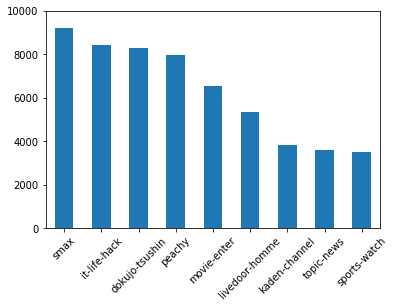

In [17]:
(df['service'].value_counts()).plot(kind='bar', rot=45, ylim=(0, 10000))

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['service'] = le.fit_transform(df.service.values)
pd.concat([df.head(3), df.tail(3)])

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
1,「『スッピンのほうがいい』とは、スッピンでもメイク時と同じくらいかわいい女性が好みだという意...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
2,●「女の子は多少、太ってるくらいがかわいいよ」\n女性は年中、ダイエットと向き合っている。ど...,2011-10-13T15:28:00+0900\n,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音\n,http://news.livedoor.com/article/detail/593428...
56628,藤村修官房長官は20日、記者会見を開き、「政府として軍事転用などという考えは一切持っていない...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56629,ニュースを受け、韓国のネット掲示板では、「日本は本当に怖い国だ」「日本がするなら我々もする」...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...
56630,一方で、「韓国、日本、台湾が全部核武装すれば真の平和が訪れるかもしれない」「各国の健全な良識...,2012-06-21T20:32:00+0900\n,8,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声\n,http://news.livedoor.com/article/detail/668154...


In [22]:
from sklearn.model_selection import train_test_split
df = df[['body', 'service']]
train_df, val_test_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_test_df, test_size=0.5)

`DataFrame` をCSV (Comma-Separated Value) やTSV (Tab-Separated Value) で保存するには `pandas.DataFrame.to_csv` メソッドを呼び出します。ひとつ目の引数 `path_or_buf` には保存先のファイルパス（もしくはファイルオブジェクト）を指定し、ふたつ目の引数 `sep` には列のセパレーターを指定します。デフォルトでは `sep=','` となっており、セパレーターはカンマ、つまり `DataFrame` はCSVで保存されます。自然言語処理を行う場合、データ内にカンマが含まれていることがあるのでしばしばセパレーターとしてはタブ (`\t`) が用いられます。ここでは `DataFrame` をTSVの形式で保存します。

In [23]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

#### ラベリング

### 前処理



#### 形態素解析
#### ストップワード除去

### 文書分類モデル





In [99]:
"""
import pandas as pd
df = pd.read_csv('news.tsv', sep='\t', index_col=0)
df = df[['body', 'service']]
df.head()
"""

"\nimport pandas as pd\ndf = pd.read_csv('news.tsv', sep='\t', index_col=0)\ndf = df[['body', 'service']]\ndf.head()\n"

In [103]:
"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['service'] = le.fit_transform(df.service.values)
df.head()
"""

"\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ndf['service'] = le.fit_transform(df.service.values)\ndf.head()\n"

In [104]:
#train_df.head()

,body,service
1536,先週前半は、嵐の前の静けさといった感じで、かなり平穏でした。それもあってニュースのネタ探しに...,1
6175,23日、千葉県総合スポーツセンター陸上競技場では、国際千葉駅伝が行われた。レースは、ケニアが...,7
5130,ゼロから始めるスマートフォン ZTEは19日（現地時間）、現在シンガポールで開催されている展...,6
1123,ドコモは2012年3月5日 、「ドコモwebメール」を2012年8月27日午前11時をもって...,1
3450,現在、全米で大ヒット継続中で、2年連続“最も好きな犯罪ドラマ”にも選ばれている人気海外ドラ...,4


In [92]:
#val_df.head()

,body,service
2513,省エネ効果があり、従来の蛍光灯や電球と違って長期間使用が可能で、しかも明るいLEDライト。今...,2
3374,ＳＦ小説の巨匠ロバート・Ａ・ハインラインの傑作『宇宙の戦士』を映画化し、巨大昆虫と戦う兵士...,4
6048,昨年12月、大阪府立体育会館で開催された、ボクシング・WBA世界ダブルタイトルマッチにおいて...,7
6894,20日、ハロープロジェクトに所属するアイドルグループ「スマイレージ」のスタッフが管理するツイ...,8
1485,先日ひと騒動あった不審なAndroidアプリの件、「ヘンなアプリに要注意！ データぶっこ抜き...,1


In [24]:
import torch
from transformers import BertForSequenceClassification
net = BertForSequenceClassification.from_pretrained('bert-base-japanese-whole-word-masking', num_labels=9)
device='cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

このニューラルネットワークの構造をnetron (https://github.com/lutzroeder/netron) というツールを用いて可視化すると次のようになります。
<img src="../figures/bert_classifier_netron.png" alt="bert_classifier_netron" width="150">
BERTモデルの構造が `BertModel` に押し込められているため、やけにシンプルに見えますが、ここではあまり深く考えないようにします。

PyTorchを用いてディープラーニングを実装する際には

In [25]:
from torchtext.data import Field
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

import re
import mojimoji

def tokenizer_with_preprocessing(text):
        # 半角、全角の変換
        text = mojimoji.han_to_zen(text)
        # 改行、半角スペース、全角スペースを削除
        text = re.sub('\r', '', text)
        text = re.sub('\n', '', text)
        text = re.sub('　', '', text)
        text = re.sub(' ', '', text)
        # 数字文字の一律「0」化
        text = re.sub(r'[0-9 ０-９]', '0', text)  # 数字
        return tokenizer.tokenize(text)
    
TEXT = Field(
    sequential=True,  
    tokenize=tokenizer_with_preprocessing, 
    use_vocab=True,
    lower=False,
    include_lengths=True,
    batch_first=True,
    fix_length=512,
    init_token='[CLS]',
    eos_token='[SEP]',
    pad_token='[PAD]',
    unk_token='[UNK]'
)
LABEL = Field(sequential=False, use_vocab=False)

In [26]:
from torchtext.data import TabularDataset
train, val, test = TabularDataset.splits(
    path='.', train='train.tsv', validation='val.tsv', test='test.tsv', format='tsv', 
    fields=[('body', TEXT), ('service', LABEL)], skip_header=True)

In [27]:
TEXT.build_vocab(train, min_freq=1)
TEXT.vocab.stoi = tokenizer.vocab

In [28]:
import torch
from torchtext.data import Iterator
batch_size = 32
#train_iter, val_iter, test_iter = Iterator.splits((train, val, test), batch_size=batch_size, device='cuda' if torch.cuda.is_available() else 'cpu')
train_iter = Iterator(train, batch_size, train=True, device=device)
val_iter = Iterator(val, batch_size, train=False, sort=False, device=device)
test_iter = Iterator(test, batch_size, train=False, sort=False, device=device)

In [29]:
iterator_dict = {'train': train_iter, 'val': val_iter, 'test': test_iter}

In [30]:
"""
net.to('cuda')
batch = next(iter(train_iter))
inputs = batch.body[0]
labels = batch.service
loss, logit = net(inputs, labels=labels)
"""

"\nnet.to('cuda')\nbatch = next(iter(train_iter))\ninputs = batch.body[0]\nlabels = batch.service\nloss, logit = net(inputs, labels=labels)\n"

In [31]:
for name, param in net.named_parameters():
    param.requires_grad = False

In [32]:
for name, param in net.bert.encoder.layer[-1].named_parameters():
    param.requires_grad = True

In [33]:
for name, param in net.classifier.named_parameters():
    param.requires_grad = True

In [34]:
optimizer = torch.optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': net.classifier.parameters(), 'lr': 5e-5}
], betas=(0.9, 0.999))

In [35]:
criterion = torch.nn.CrossEntropyLoss()

In [36]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='./logs/' + datetime.today().isoformat(timespec='seconds'))

def train_model(net, iterator_dict, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    iteration = 1
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.
            epoch_corrects = 0
            
            for batch in iterator_dict[phase]:
                inputs = batch.body[0]
                labels = batch.service
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    loss, logit = net(input_ids=inputs, labels=labels)
                    #print(loss, logit)
                    _, preds = torch.max(logit, 1)
                    #predictions.append(preds.cpu().numpy())
                    #ground_truths.append(labels.data.cpu().numpy())
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        if (iteration % 10 == 0):
                            acc = (torch.sum(preds == labels.data)).double() / batch_size
                            print('iteration {} || Loss: {:.4f} || acc {}'.format(
                                iteration, loss.item(), acc.item()))
                            writer.add_scalar("Loss/{}".format(phase), loss.item(), iteration)
                            writer.add_scalar("Accuracy/{}".format(phase), acc.item(), iteration)
                        iteration += 1
                    
                    epoch_loss += loss.item() * batch_size
                    #print(preds, labels.data)
                    epoch_corrects += torch.sum(preds == labels.data)
        epoch_loss = epoch_loss / len(iterator_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(iterator_dict[phase].dataset)
        writer.add_scalar("Loss/{}".format(phase), epoch_loss, epoch)
        writer.add_scalar("Accuracy/{}".format(phase), epoch_acc, epoch)
        
        print('Epoch {}/{} | {} | Loss: {:.4f} Acc: {:.4f}'.format(
            epoch+1, num_epochs, phase, epoch_loss, epoch_acc))
    return net

In [ ]:
num_epochs = 100 
net_trained = train_model(net, iterator_dict, criterion, optimizer, num_epochs)

iteration 10 || Loss: 2.0988 || acc 0.21875
iteration 20 || Loss: 2.1861 || acc 0.125
iteration 30 || Loss: 2.1202 || acc 0.125
iteration 40 || Loss: 2.1214 || acc 0.09375
iteration 50 || Loss: 2.1458 || acc 0.15625
iteration 60 || Loss: 2.2081 || acc 0.21875
iteration 70 || Loss: 2.0628 || acc 0.3125
iteration 80 || Loss: 1.9948 || acc 0.21875
iteration 90 || Loss: 2.0105 || acc 0.25
iteration 100 || Loss: 1.9557 || acc 0.21875
iteration 110 || Loss: 2.1051 || acc 0.25
iteration 120 || Loss: 1.8721 || acc 0.40625
iteration 130 || Loss: 1.7807 || acc 0.34375
iteration 140 || Loss: 1.6750 || acc 0.375
iteration 150 || Loss: 1.7118 || acc 0.34375
iteration 160 || Loss: 1.4633 || acc 0.625
iteration 170 || Loss: 1.5476 || acc 0.4375
iteration 180 || Loss: 1.5173 || acc 0.46875
iteration 190 || Loss: 1.0899 || acc 0.65625
iteration 200 || Loss: 1.2870 || acc 0.65625
iteration 210 || Loss: 1.1704 || acc 0.65625
iteration 220 || Loss: 1.3619 || acc 0.4375
iteration 230 || Loss: 1.1498 || acc

iteration 2020 || Loss: 0.8275 || acc 0.71875
iteration 2030 || Loss: 1.0793 || acc 0.65625
iteration 2040 || Loss: 1.1377 || acc 0.59375
iteration 2050 || Loss: 0.7735 || acc 0.6875
iteration 2060 || Loss: 0.7707 || acc 0.78125
iteration 2070 || Loss: 0.8088 || acc 0.78125
iteration 2080 || Loss: 1.0223 || acc 0.625
iteration 2090 || Loss: 0.8500 || acc 0.78125
iteration 2100 || Loss: 0.8279 || acc 0.78125
iteration 2110 || Loss: 0.7156 || acc 0.78125


### 評価と比較

### モデルのデプロイ

## まとめ

## 参考文献

- [(Part 1) tensorflow2でhuggingfaceのtransformersを使ってBERTを文書分類モデルに転移学習する](https://tksmml.hatenablog.com/entry/2019/10/22/215000)
- [(Part 2) tensorflow 2 でhugging faceのtransformers公式のBERT日本語学習済みモデルを文書分類モデルにfine-tuningする](https://tksmml.hatenablog.com/entry/2019/12/15/090900)
- [All Models and checkpoints](https://huggingface.co/models)
- [Working with GPU packages](https://docs.anaconda.com/anaconda/user-guide/tasks/gpu-packages/)
- [gensimとPyTorchを使ったlive doorニュースコーパスのテキスト分類](https://www.pytry3g.com/entry/2018/04/03/194202)
- [bert-japanese](https://github.com/cl-tohoku/bert-japanese)
- [DocumentClassificationUsingBERT-Japanese](https://github.com/nekoumei/DocumentClassificationUsingBERT-Japanese)
- [torchtext](https://torchtext.readthedocs.io/en/latest/index.html)
- [FX予測 : PyTorchのBERTで経済ニュース解析](https://qiita.com/THERE2/items/8b7c94787911fad8daa6)
- [torchtextで簡単にDeepな自然言語処理](https://qiita.com/itok_msi/items/1f3746f7e89a19dafac5)
- [transformers](https://github.com/huggingface/transformers)
- [BERTを使った文章要約 [身内向け]](https://qiita.com/IwasakiYuuki/items/25f5bbcde4f82dff7f1a)
- [MeCab + Gensim による日本語の自然言語処理](https://www.koi.mashykom.com/nlp.html)
- [論文解説 Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (GNMT)](http://deeplearning.hatenablog.com/entry/gnmt)
- [BERT with SentencePiece で日本語専用の pre-trained モデルを学習し、それを基にタスクを解く](https://techlife.cookpad.com/entry/2018/12/04/093000)
- [はじめての自然言語処理](https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/)